# Spike Gadgets Ephys and Video Syncing

# TODO

- [] Refactor the trodes extraction functions

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_182514/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [12]:
protocol_name = "tethered_with_medpc"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [13]:
input_folder = "./data"

In [14]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [23]:
raw_data_glob_pattern = "./data/20221122_161341_omission_subject_6_1_and_6_3.rec"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [24]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [25]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [26]:
raw_data_file_path

'./data/20221122_161341_omission_subject_6_1_and_6_3.rec'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [34]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: LFP_nt15ch1.dat
directory prefix: LFP
file prefix: LFP_nt16ch1.dat
directory prefix: LFP
file prefix: LFP_nt7ch1.dat
directory prefix: LFP
file prefix: LFP_nt5ch1.dat
directory prefix: LFP
file prefix: LFP_nt2ch1.dat
directory prefix: LFP
file prefix: LFP_nt17ch1.dat
directory prefix: LFP
file prefix: LFP_nt9ch1.dat
directory prefix: LFP
file prefix: LFP_nt13ch1.dat
directory prefix: LFP
file prefix: LFP_nt6ch1.dat
directory prefix: LFP
file prefix: LFP_nt14ch1.dat
directory prefix: LFP
file prefix: LFP_nt19ch1.dat
directory prefix: LFP
file prefix: LFP_nt23ch1.dat
directory prefix: LFP
file prefix: LFP_nt11ch1.dat
directory prefix: LFP
file prefix: LFP_nt20ch1.dat
directory prefix: LFP
file prefix: LFP_nt32ch1.dat
directory prefix: LFP
file prefix: LFP_nt31ch1.dat
directory prefix: L

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_3_top_1_base_3.timestampoffset/20221122_161341_omission_subject_6_3_top_1_base_3.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: spikeband_nt13ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt8ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt29ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt12ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt14ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt25ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt16ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt1ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt26ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt11ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt7ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt18ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt31ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt4ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt22ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt15ch1.dat
directory prefix: spikeb

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_3_top_1_base_3.kilosort/20221122_161341_omission_subject_6_3_top_1_base_3.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: raw_group0.dat
directory prefix: raw
file prefix: timestamps.dat
directory prefix: raw
file prefix: spikes_nt19.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt15.dat
directory prefix: spikes
file prefix: spikes_nt32.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt24.dat
directory prefix: spikes
file prefix: spikes_nt17.dat
directory prefix: spikes
file prefix: spikes_nt18.dat
directory prefix: spikes
file prefix: spikes_nt2.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt31.dat
directory prefix: spikes
file prefix: spikes_nt13.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt27.dat
directory prefix: spikes
file prefix: spikes_nt4.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory pre

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_top_4_base_2.mountainsort/20221122_161341_omission_subject_6_1_top_4_base_2.group0.mda
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject

file prefix: timestamps.dat
directory prefix: stimulation
file prefix: spikes_nt28.dat
directory prefix: spikes
file prefix: spikes_nt31.dat
directory prefix: spikes
file prefix: spikes_nt15.dat
directory prefix: spikes
file prefix: spikes_nt32.dat
directory prefix: spikes
file prefix: spikes_nt16.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt26.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt22.dat
directory prefix: spikes
file prefix: spikes_nt1.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory prefix: spikes
file prefix: spikes_nt4.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt29.dat
directory prefix: spikes
file prefix: spikes_nt11.dat
directory prefix: spikes
file prefix: spikes_nt21.dat
d

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_top_4_base_2.kilosort/20221122_161341_omission_subject_6_1_top_4_base_2.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: timestamps.dat
directory prefix: kilosort
file prefix: timestamps.dat
directory prefix: stimulation
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: LFP_nt5ch1.dat
directory prefix: LFP
file prefix: LFP_nt14ch1.dat
directory prefix: LFP
file prefix: LFP_nt9ch1.dat
directory prefix: LFP
file prefix: LFP_nt21ch1.dat
directory prefix: LFP
file prefix: LFP_nt4ch1.dat
directory prefix: LFP
file prefix: LFP_nt23ch1.dat
directory prefix: LFP
file prefix: LFP_nt1ch1.dat
directory prefix: LFP
file prefix: LFP_nt30ch1.dat
directory prefix: LFP
file prefix: LFP_nt17ch1.dat
directory prefix: LFP
file prefix: LFP_nt11ch1.dat
directory prefix: LFP
file prefix: LFP_nt31ch1.dat
directory prefix: LFP
file prefix: LFP_nt16ch1.dat
directory prefix: LFP
file prefix: LFP_nt27ch1.dat
directory prefix: LFP
file prefix: LFP_nt22ch1.dat
directory prefix: LFP
file prefix: LFP_nt26ch1.dat
directory prefix: LFP
file prefix: LFP_nt12ch1.dat
directory prefix: LFP
file prefix

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_3_top_1_base_3.mountainsort/20221122_161341_omission_subject_6_3_top_1_base_3.timestamps.mda
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_sub

file prefix: timestamps.dat
directory prefix: time


- All the folders that were extracted from

In [35]:
file_to_data.keys()

dict_keys(['.', '20221122_161341_omission_subject_6_3_top_1_base_3.LFP', 'LFP', '20221122_161341_omission_subject_6_3_top_1_base_3.raw', 'raw', 'old', '20221122_161341_omission_subject_6_3_top_1_base_3.timestampoffset', '20221122_161341_omission_subject_6_1_top_4_base_2.spikeband', 'spikeband', '20221122_161341_omission_subject_6_3_top_1_base_3.analog', 'analog', '20221122_161341_omission_subject_6_3_top_1_base_3.time', 'time', '20221122_161341_omission_subject_6_3_top_1_base_3.kilosort', 'kilosort', '20221122_161341_omission_subject_6_3_top_1_base_3.DIO', 'DIO', '20221122_161341_omission_subject_6_1_top_4_base_2.raw', '20221122_161341_omission_subject_6_1_top_4_base_2.spikes', 'spikes', '20221122_161341_omission_subject_6_1_top_4_base_2.analog', '20221122_161341_omission_subject_6_1_top_4_base_2.mountainsort', 'mountainsort', '20221122_161341_omission_subject_6_1_top_4_base_2.DIO', '20221122_161341_omission_subject_6_1_top_4_base_2.timestampoffset', '20221122_161341_omission_subject_6

In [36]:
file_to_data["."]

{'1.videoTimeStamps.cameraHWSync': {'clock rate': '30000',
  'fields': '<PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>',
  'data': array([( 3772335, 0, 0), ( 3773721, 0, 0), ( 3773721, 0, 0), ...,
         (30997743, 0, 0), (30997743, 0, 0), (30999129, 0, 0)],
        dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')]),
  'absolute_file_path': '/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_and_6_3.1.videoTimeStamps.cameraHWSync'}}

In [37]:
file_to_data["20221122_161341_omission_subject_6_1_top_4_base_2.spikeband"]

{'spikeband_nt13ch1.dat': {'description': 'Spike band continuous data for one channel',
  'byte_order': 'little endian',
  'original_file': '20221122_161341_omission_subject_6_1_top_4_base_2.rec',
  'clockrate': '20000',
  'trodes_version': '2.3.2',
  'compile_date': 'Apr 12 2022',
  'compile_time': '15:21:02',
  'qt_version': '6.2.2',
  'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
  'controller_firmware': '3.17',
  'headstage_firmware': '2.2',
  'controller_serialnum': '00104 00176',
  'headstage_serialnum': '01601 00133',
  'autosettle': '0',
  'smartref': '0',
  'gyro': '0',
  'accelerometer': '0',
  'magnetometer': '1',
  'time_offset': '0',
  'system_time_at_creation': '1669151645752',
  'timestamp_at_creation': '3722444',
  'first_timestamp': '3772337',
  'ntrode_id': '13',
  'num_channels': '1',
  'voltage_scaling': '0.195',
  'reference': 'off',
  'spike_invert': 'yes',
  'fields': '<voltage int16>',
  'data': array([(-163,), ( -87,), (  -3,), ..., ( 297,), ( 204,), ( 170,)

- Looking over all the extracted data

In [38]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: .
	File Name: 1.videoTimeStamps.cameraHWSync

 	 	 Trodes Data Type: clock rate
	 	 Python Type: <class 'str'>
	 	 Data Value: 30000

 	 	 Trodes Data Type: fields
	 	 Python Type: <class 'str'>
	 	 Data Value: <PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>

 	 	 Trodes Data Type: data
	 	 Python Type: <class 'numpy.ndarray'>
	 	 Data Value: [( 3772335, 0, 0) ( 3773721, 0, 0) ( 3773721, 0, 0) ... (30997743, 0, 0)
 (30997743, 0, 0) (30999129, 0, 0)]

 	 	 Trodes Data Type: absolute_file_path
	 	 Python Type: <class 'str'>
	 	 Data Value: /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_pca_plotting_subj_6_1_and_6_3/data/20221122_161341_omission_subject_6_1_and_6_3.rec/20221122_161341_omission_subject_6_1_and_6_3.1.videoTimeStamps.cameraHWSync
Directory: 20221122_161341_omission_subject_6_3_top_1_base_3.LFP
	File Name: LFP_nt15ch1.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class '

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [39]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [40]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [41]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [42]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221122_161341_omission_subject_6_1_top_4_base_2.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00133',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1669151645752',
 'timestamp_at_creation': '3722444',
 'first_timestamp': '3772337',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([  57,  149,   79, -102,  -26,   96,  -14,  168,  201,  212,  278,   76,  186, -134, -396,  115, -743,  263,  226,   84,  205,  224,  217,  168,  1

- Array of Voltages for each channel

In [43]:
voltage_value_array = raw_recording_fields_text["data"]

In [44]:
voltage_value_array.shape

(22906880,)

In [45]:
voltage_value_array[:5]

array([([  57,  149,   79, -102,  -26,   96,  -14,  168,  201,  212,  278,   76,  186, -134, -396,  115, -743,  263,  226,   84,  205,  224,  217,  168,  179,   93,  -54,   90,  -54,   31,   48,  132],),
       ([ 131,  132,  148,  -46,  -69,    1,   -1,  111,  236,  237,  256,  144,  103, -116, -398,   94, -769,  312,   58,   57,  243,  265,  220,  280,  242,   99,  -87,  203,    5,  201,   40,  164],),
       ([ 142,  225,   60,   13,   -8,   19,  -34,  171,  243,  238,  234,  -72,   32,  -94, -332,   68, -696,  360,  171,  156,  213,  325,  324,  308,  270,  100,   20,  156,   58,  164,  109,  154],),
       ([ 157,  290,  108,  109,   89,  124,   77,  223,  232,  248,  356,  183,   56,  -50, -261,  129, -673,  406,   43,  -53,  197,  285,  296,  281,  247,  122,  131,  112,  -77,   85,  103,  200],),
       ([ 137,  306,  196,   13,    1,  189,   90,  213,  269,  243,  395,  155,  177,   70, -190,  161, -647,  484,  129,  156,  298,  409,  345,  312,  280,  166,  125,  201,  -46,  

- Voltage Time Stamps

In [46]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [47]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [48]:
voltage_timestamp_array[:5]

array([(3772337,), (3772338,), (3772339,), (3772340,), (3772341,)],
      dtype=[('time', '<u4')])

In [49]:
voltage_timestamp_array[-5:]

array([(26693548,), (26693549,), (26693550,), (26693551,), (26693552,)],
      dtype=[('time', '<u4')])

In [50]:
voltage_timestamp_array.shape

(22921216,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [51]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [52]:
voltage_timestamp_array[:5]

array([3772337, 3772338, 3772339, 3772340, 3772341])

In [53]:
voltage_timestamp_array[-5:]

array([26693548, 26693549, 26693550, 26693551, 26693552])

In [54]:
voltage_timestamp_array.shape

(22921216,)

# Part 3: Converting everything into timestamps

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [62]:
random_voltage_index = np.random.choice(voltage_timestamp_array.shape[0], 1, replace=False)  

In [63]:
random_voltage_index

array([13517224])

In [64]:
voltage_value_array[random_voltage_index]

array([([-430, -325, -202, -317, -404, -375, -306, -307, -255, -721, -410, -340, -291,  -93, -299, -872, -249, -226, -222, -434, -315, -318, -481, -417, -333, -361, -354, -414, -509,  -53, -265,  -97],)],
      dtype=[('voltage', '<i2', (32,))])

- Getting the associated timestamp of the ephys recording

In [91]:
random_voltage_time_stamp = voltage_timestamp_array[random_voltage_index]

In [92]:
random_voltage_time_stamp

array([17289561])

# Part 4: Converting from timestamps back to everything

In [93]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [94]:
random_voltage_time_stamp

array([17289561])

In [95]:
voltage_timestamp_array

array([ 3772337,  3772338,  3772339, ..., 26693550, 26693551, 26693552])

- Getting the index of the closest timestamp 

In [96]:
random_voltage_index = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=voltage_timestamp_array)

In [97]:
random_voltage_index

13517224

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [98]:
voltage_timestamp_array[random_voltage_index]

17289561

- Getting the voltage value based on the index

In [99]:
voltage_value_array[random_voltage_index]

([-430, -325, -202, -317, -404, -375, -306, -307, -255, -721, -410, -340, -291,  -93, -299, -872, -249, -226, -222, -434, -315, -318, -481, -417, -333, -361, -354, -414, -509,  -53, -265,  -97],)

# Part 4: Syncing everything based on timestamps

# Syncing with MED-PC

In [100]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [101]:
DIO_directory_name

'DIO'

In [102]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [103]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout24.dat', 'dio_ECU_Dout26.dat', 'dio_ECU_Din4.dat', 'dio_ECU_Dout6.dat', 'dio_ECU_Din3.dat', 'dio_ECU_Din2.dat', 'dio_ECU_Dout16.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Din14.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Dout15.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Dout1.dat', 'dio_Controller_Din7.dat', 'dio_ECU_Din8.dat', 'dio_ECU_Dout5.dat', 'dio_ECU_Dout8.dat', 'dio_ECU_Din27.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Dout19.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Dout29.dat', 'dio_ECU_Dout22.dat', 'dio_ECU_Din22.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Din30.dat', 'dio_ECU_Din10.dat', 'dio_ECU_Dout12.dat', 'dio_Controller_Din5.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Dout28.dat', 'dio_Controller_Din4.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Din5.dat', 'dio_ECU_Dout32.dat', 'dio_Controller_Din6.dat', 'dio_Controller_Din8.dat', 'dio_ECU_Din7.dat', 

In [105]:
DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [106]:
DIN_file_name

'dio_ECU_Din1.dat'

In [107]:
DIN_state_array = DIO_directory_dict[DIN_file_name]["data"]

In [108]:
DIN_state_array

array([( 3772337, 1), ( 4003716, 0), ( 5204112, 1), ( 5404109, 0),
       ( 6804107, 1), ( 7004109, 0), ( 8604101, 1), ( 8804103, 0),
       (10204096, 1), (10404098, 0), (11704091, 1), (11904090, 0),
       (13704085, 1), (13904082, 0), (15604082, 1), (15804078, 0),
       (17404074, 1), (17604073, 0), (19004066, 1), (19204065, 0),
       (20804062, 1), (21004062, 0), (22804059, 1), (23004055, 0),
       (24604051, 1), (24804050, 0), (27004044, 1), (27204043, 0),
       (28804038, 1), (29004037, 0), (29203637, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

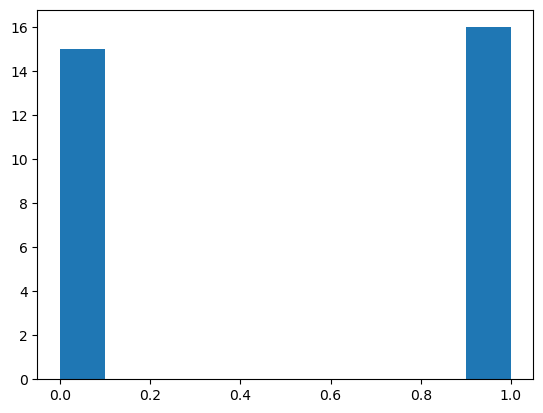

In [117]:
plt.hist([tup[1] for tup in DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

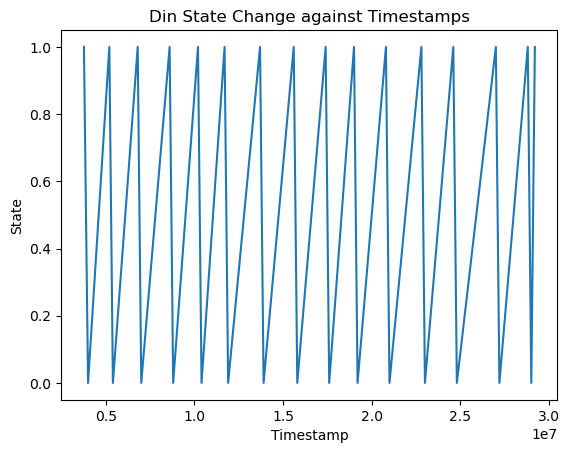

In [118]:
plt.plot([tup[0] for tup in DIN_state_array], [tup[1] for tup in DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

# Reading in Phy

- The times that all the spikes happened

In [120]:
spike_times = np.load("./subject_6_1/proc/phy/spike_times.npy")

In [125]:
spike_times[:10]

array([[ 32],
       [106],
       [156],
       [201],
       [246],
       [281],
       [349],
       [386],
       [479],
       [559]])

- Which unit the spike came from

In [122]:
spike_clusters = np.load("./subject_6_1/proc/phy/spike_clusters.npy")

In [126]:
spike_clusters[:10]

array([64,  6, 59, 23, 23, 27, 27,  9, 55, 56], dtype=int32)

- The classification of each unit

In [123]:
cluster_group_df = pd.read_csv("./subject_6_1/proc/phy/cluster_group.tsv", sep="\t")

In [127]:
cluster_group_df

cluster_id  group
0            1  noise
1            2  noise
2            4   good
3            5  noise
4            6   good
..         ...    ...
70          90  noise
71          93    mua
72          94  noise
73         101   good
74         102  noise

[75 rows x 2 columns]

In [163]:
good_unit_unique_ids = cluster_group_df[cluster_group_df["group"] == "good"]["cluster_id"].values

In [164]:
good_unit_unique_ids

array([  4,   6,  10,  12,  15,  48,  53,  55,  64,  71,  73,  79,  83,
       101])

In [165]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [168]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [170]:
good_unit_all_ids.shape

(144276,)

In [171]:
good_unit_all_ids[:10]

array([64,  6, 55, 15,  6, 55, 10, 15,  6, 55], dtype=int32)

In [166]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [162]:
good_unit_times.shape

(144276,)

In [149]:
good_unit_times[:10]

array([  32,  106,  479, 1120, 1383, 1493, 1668, 1740, 2353, 2600])

In [172]:
good_unit_times[-10:]

array([56842855, 56843167, 56844643, 56844863, 56846404, 56865558,
       56891994, 56935888, 56949135, 56997479])

In [151]:
voltage_timestamp_array

array([ 3772337,  3772338,  3772339, ..., 26693550, 26693551, 26693552])

In [154]:
DIN_state_array

array([( 3772337, 1), ( 4003716, 0), ( 5204112, 1), ( 5404109, 0),
       ( 6804107, 1), ( 7004109, 0), ( 8604101, 1), ( 8804103, 0),
       (10204096, 1), (10404098, 0), (11704091, 1), (11904090, 0),
       (13704085, 1), (13904082, 0), (15604082, 1), (15804078, 0),
       (17404074, 1), (17604073, 0), (19004066, 1), (19204065, 0),
       (20804062, 1), (21004062, 0), (22804059, 1), (23004055, 0),
       (24604051, 1), (24804050, 0), (27004044, 1), (27204043, 0),
       (28804038, 1), (29004037, 0), (29203637, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

In [174]:
tone_din_time = [(din_time, din_state) for din_time, din_state in DIN_state_array if din_state == 1]

In [175]:
tone_din_time

[(3772337, 1),
 (5204112, 1),
 (6804107, 1),
 (8604101, 1),
 (10204096, 1),
 (11704091, 1),
 (13704085, 1),
 (15604082, 1),
 (17404074, 1),
 (19004066, 1),
 (20804062, 1),
 (22804059, 1),
 (24604051, 1),
 (27004044, 1),
 (28804038, 1),
 (29203637, 1)]

In [179]:
all_tone_unit_time = [tone_unit_time - voltage_timestamp_array[0] for tone_unit_time, din_state in tone_din_time]

In [180]:
all_tone_unit_time

[0,
 1431775,
 3031770,
 4831764,
 6431759,
 7931754,
 9931748,
 11831745,
 13631737,
 15231729,
 17031725,
 19031722,
 20831714,
 23231707,
 25031701,
 25431300]

In [183]:
[x / 20000 for x in all_tone_unit_time]

[0.0,
 71.58875,
 151.5885,
 241.5882,
 321.58795,
 396.5877,
 496.5874,
 591.58725,
 681.58685,
 761.58645,
 851.58625,
 951.5861,
 1041.5857,
 1161.58535,
 1251.58505,
 1271.565]

- So we must remove first and last instance because they are just the start and stop of the program and not the actual tone

In [184]:
all_tone_unit_time = all_tone_unit_time[1:-1]

In [185]:
all_tone_unit_time

[1431775,
 3031770,
 4831764,
 6431759,
 7931754,
 9931748,
 11831745,
 13631737,
 15231729,
 17031725,
 19031722,
 20831714,
 23231707,
 25031701]

In [201]:
len(all_tone_unit_time)

14

## Seeing which tone time each unit time is closest to

- checking which bin each unit time is in

In [199]:
good_unit_bins = np.digitize(good_unit_times, all_tone_unit_time, right=True)

In [202]:
good_unit_bins.shape

(144276,)

In [200]:
good_unit_bins

array([ 0,  0,  0, ..., 14, 14, 14])

In [203]:
within_interval_unit_times = []
for index, time in enumerate(good_unit_times):
    print(good_unit_bins[index])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
1

In [212]:
within_interval_unit_times = []
for index, time in enumerate(good_unit_times):
    try:
        current_bin = good_unit_bins[index]


        # checking number before
        first_tone_time = all_tone_unit_time[current_bin - 1]
        if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 5 * 20000:
            within_interval_unit_times.append((index, time, first_tone_time))

        # checking number after
        second_tone_time = all_tone_unit_time[current_bin]
        if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 5 * 20000:
            within_interval_unit_times.append((index, time, second_tone_time))
    except:
        pass

In [213]:
within_interval_unit_times

[(4051, 1331964, 1431775),
 (4052, 1332422, 1431775),
 (4053, 1332513, 1431775),
 (4054, 1332786, 1431775),
 (4055, 1333224, 1431775),
 (4056, 1333491, 1431775),
 (4057, 1333971, 1431775),
 (4058, 1334117, 1431775),
 (4059, 1334431, 1431775),
 (4060, 1335551, 1431775),
 (4061, 1335630, 1431775),
 (4062, 1336054, 1431775),
 (4063, 1336256, 1431775),
 (4064, 1336582, 1431775),
 (4065, 1337019, 1431775),
 (4066, 1337133, 1431775),
 (4067, 1337390, 1431775),
 (4068, 1337727, 1431775),
 (4069, 1338125, 1431775),
 (4070, 1338622, 1431775),
 (4071, 1338666, 1431775),
 (4072, 1338738, 1431775),
 (4073, 1339225, 1431775),
 (4074, 1339427, 1431775),
 (4075, 1340144, 1431775),
 (4076, 1340310, 1431775),
 (4077, 1340472, 1431775),
 (4078, 1340982, 1431775),
 (4079, 1341724, 1431775),
 (4080, 1342021, 1431775),
 (4081, 1342141, 1431775),
 (4082, 1342375, 1431775),
 (4083, 1343458, 1431775),
 (4084, 1343750, 1431775),
 (4085, 1344143, 1431775),
 (4086, 1344354, 1431775),
 (4087, 1344475, 1431775),
 

## Seeing which bin for the time that the unit time belongs to

In [214]:
len(within_interval_unit_times)

9416

In [ ]:
range(1431775, 

In [188]:
[(1431775 + num * 2000, 1431775 + (num + 1) * 2000) for num in range(50)]

[(1431775, 1433775),
 (1433775, 1435775),
 (1435775, 1437775),
 (1437775, 1439775),
 (1439775, 1441775),
 (1441775, 1443775),
 (1443775, 1445775),
 (1445775, 1447775),
 (1447775, 1449775),
 (1449775, 1451775),
 (1451775, 1453775),
 (1453775, 1455775),
 (1455775, 1457775),
 (1457775, 1459775),
 (1459775, 1461775),
 (1461775, 1463775),
 (1463775, 1465775),
 (1465775, 1467775),
 (1467775, 1469775),
 (1469775, 1471775),
 (1471775, 1473775),
 (1473775, 1475775),
 (1475775, 1477775),
 (1477775, 1479775),
 (1479775, 1481775),
 (1481775, 1483775),
 (1483775, 1485775),
 (1485775, 1487775),
 (1487775, 1489775),
 (1489775, 1491775),
 (1491775, 1493775),
 (1493775, 1495775),
 (1495775, 1497775),
 (1497775, 1499775),
 (1499775, 1501775),
 (1501775, 1503775),
 (1503775, 1505775),
 (1505775, 1507775),
 (1507775, 1509775),
 (1509775, 1511775),
 (1511775, 1513775),
 (1513775, 1515775),
 (1515775, 1517775),
 (1517775, 1519775),
 (1519775, 1521775),
 (1521775, 1523775),
 (1523775, 1525775),
 (1525775, 15

In [193]:
[(1431775 - (num + 1) * 2000, 1431775 - num * 2000) for num in range(50)][::-1]

[(1331775, 1333775),
 (1333775, 1335775),
 (1335775, 1337775),
 (1337775, 1339775),
 (1339775, 1341775),
 (1341775, 1343775),
 (1343775, 1345775),
 (1345775, 1347775),
 (1347775, 1349775),
 (1349775, 1351775),
 (1351775, 1353775),
 (1353775, 1355775),
 (1355775, 1357775),
 (1357775, 1359775),
 (1359775, 1361775),
 (1361775, 1363775),
 (1363775, 1365775),
 (1365775, 1367775),
 (1367775, 1369775),
 (1369775, 1371775),
 (1371775, 1373775),
 (1373775, 1375775),
 (1375775, 1377775),
 (1377775, 1379775),
 (1379775, 1381775),
 (1381775, 1383775),
 (1383775, 1385775),
 (1385775, 1387775),
 (1387775, 1389775),
 (1389775, 1391775),
 (1391775, 1393775),
 (1393775, 1395775),
 (1395775, 1397775),
 (1397775, 1399775),
 (1399775, 1401775),
 (1401775, 1403775),
 (1403775, 1405775),
 (1405775, 1407775),
 (1407775, 1409775),
 (1409775, 1411775),
 (1411775, 1413775),
 (1413775, 1415775),
 (1415775, 1417775),
 (1417775, 1419775),
 (1419775, 1421775),
 (1421775, 1423775),
 (1423775, 1425775),
 (1425775, 14

In [158]:
(4003716 - 3772337) / 20000

11.56895

In [159]:
(5204112 - 4003716) / 20000 

60.0198

In [160]:
(5404109 - 5204112) / 20000

9.99985

In [161]:
(6804107 - 5404109) / 20000

69.9999

In [153]:
3772337/20000/3600*60

3.143614166666667

In [119]:
raise ValueError()

ValueError: 

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [93]:
DIN_state_array

array([(39104773, 0), (40153288, 1), (40453274, 0), (42553166, 1),
       (42853151, 0), (45253029, 1), (45553013, 0)],
      dtype=[('time', '<u4'), ('state', 'u1')])

In [94]:
DIN_time_stamp = DIN_state_array[5][0]

In [95]:
DIN_time_stamp

45253029

- Array of the time stamp of all the frames

In [96]:
pos_timestamp_array

array([39104810, 39106160, 39107726, ..., 45870150, 45871601, 45872946])

- Getting the first video time stamp that is greater than the voltage time stamp

In [97]:
current_video_frame = timestamp_to_index(current_ts=DIN_time_stamp, ts_array=pos_timestamp_array)

In [98]:
current_video_frame

4092

## Getting the specific frame

In [99]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

Frame count: 4504


- Original frame number(before light turns on)

In [100]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [101]:
corrected_video_frame = current_video_frame + 2

In [102]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


True

In [103]:
_, frame = cap.read()

In [104]:
video_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.mp4'

In [105]:
output_directory = "./proc"

In [106]:
output_directory

'./proc'

In [107]:
os.makedirs(output_directory, exist_ok=True)

In [108]:
video_file_basename = os.path.basename(video_file_path)

In [109]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [110]:
video_file_root

'20220907_140232test.1'

In [111]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

True

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [112]:
current_video_seconds = corrected_video_frame / fps

In [113]:
current_video_seconds

303.1917665679889

In [114]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

MED-PC signal is at 5:3


# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [115]:
voltage_timestamp_array[:5]

array([39104773, 39104774, 39104775, 39104776, 39104777])

In [116]:
voltage_timestamp_array.shape

(6768567,)

In [117]:
voltage_value_array[:5]

array([([-1084,  -723,  -380,  -972,  -469, -1199,  -671,  -491,   -24, -3433, -2578, -2087,  -239,   184,   814,  -516,  -970,  -770,   163,  -114,    37, -3377,  -560,   -84,  -411, -3802, -3509, -3242, -2075,  -365,  -525, -1193],),
       ([-1007,  -754,  -376, -1010,  -538, -1231,  -658,  -375,   -81, -3450, -2511, -2036,  -197,   184,   798,  -430, -1001,  -790,   114,   -18,    59, -3321,  -587,  -161,  -280, -3843, -3478, -3174, -2050,  -370,  -493, -1179],),
       ([ -986,  -687,  -381, -1062,  -506, -1231,  -644,  -403,   -30, -3431, -2575, -2068,  -128,   185,   773,  -430,  -970,  -781,   -12,   -72,    47, -3259,  -635,  -206,  -241, -3756, -3493, -3180, -2116,  -361,  -554, -1129],),
       ([-1003,  -719,  -381, -1107,  -400, -1260,  -647,  -404,    17, -3392, -2626, -2089,  -261,   211,   748,  -430,  -944,  -737,    13,  -109,    15, -3216,  -571,  -115,  -367, -3800, -3463, -3239, -2116,  -462,  -511, -1098],),
       ([-1051,  -729,  -381, -1105,  -447, -1273,  -632

In [118]:
voltage_value_array.shape

(6768567,)

- Adding the voltage timestamps

In [119]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [120]:
ephys_dataframe.head()

voltage_time_stamp
0            39104773
1            39104774
2            39104775
3            39104776
4            39104777

- Adding the voltage value

In [121]:
ephys_dataframe["voltage_value"] = voltage_value_array.tolist()

In [122]:
ephys_dataframe.head()

voltage_time_stamp                                      voltage_value
0            39104773  ([-1084, -723, -380, -972, -469, -1199, -671, ...
1            39104774  ([-1007, -754, -376, -1010, -538, -1231, -658,...
2            39104775  ([-986, -687, -381, -1062, -506, -1231, -644, ...
3            39104776  ([-1003, -719, -381, -1107, -400, -1260, -647,...
4            39104777  ([-1051, -729, -381, -1105, -447, -1273, -632,...

## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [123]:
video_time_stamp_dict["data"][:5]

array([(39104810, 30742, 0), (39106160, 30743, 0), (39107726, 30744, 0),
       (39108939, 30745, 0), (39110620, 30746, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [124]:
video_time_stamp_dict["data"][-5:]

array([(45866941, 35242, 0), (45868124, 35243, 0), (45870150, 35244, 0),
       (45871601, 35245, 0), (45872946, 35246, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [125]:
video_dataframe = pd.DataFrame(video_time_stamp_dict["data"])

In [126]:
video_dataframe.head()

PosTimestamp  HWframeCount  HWTimestamp
0      39104810         30742            0
1      39106160         30743            0
2      39107726         30744            0
3      39108939         30745            0
4      39110620         30746            0

- Adding the frames which would just be the number in the list that the timestamps belongs to

In [127]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [128]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [129]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [130]:
video_dataframe

frame_number  PosTimestamp  HWframeCount  HWTimestamp  video_time  \
0                1      39104810         30742            0    0.074058   
1                2      39106160         30743            0    0.148115   
2                3      39107726         30744            0    0.222173   
3                4      39108939         30745            0    0.296230   
4                5      39110620         30746            0    0.370288   
...            ...           ...           ...          ...         ...   
4500          4501      45866941         35242            0  333.333205   
4501          4502      45868124         35243            0  333.407263   
4502          4503      45870150         35244            0  333.481320   
4503          4504      45871601         35245            0  333.555378   
4504          4505      45872946         35246            0  333.629435   

      video_seconds  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
4500            333  
4501            333  
4502            333  
4503            333  
4504            333  

[4505 rows x 6 columns]

## Combining the ephys and video dataframe into one

In [131]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [132]:
ephy_and_video_dataframe

voltage_time_stamp  \
0                  39104773   
1                  39104774   
2                  39104775   
3                  39104776   
4                  39104777   
...                     ...   
6768562            45873335   
6768563            45873336   
6768564            45873337   
6768565            45873338   
6768566            45873339   

                                             voltage_value  frame_number  \
0        ([-1084, -723, -380, -972, -469, -1199, -671, ...           NaN   
1        ([-1007, -754, -376, -1010, -538, -1231, -658,...           NaN   
2        ([-986, -687, -381, -1062, -506, -1231, -644, ...           NaN   
3        ([-1003, -719, -381, -1107, -400, -1260, -647,...           NaN   
4        ([-1051, -729, -381, -1105, -447, -1273, -632,...           NaN   
...                                                    ...           ...   
6768562  ([1864, 3916, 3009, 748, 768, 1155, 612, 584, ...           NaN   
6768563  ([1986, 3960, 2965, 770, 710, 1196, 659, 649, ...           NaN   
6768564  ([2008, 3916, 3036, 753, 616, 1162, 759, 653, ...           NaN   
6768565  ([1981, 3942, 3086, 892, 644, 1098, 685, 616, ...           NaN   
6768566  ([2051, 3955, 3040, 932, 691, 1063, 611, 731, ...           NaN   

         PosTimestamp  HWframeCount  HWTimestamp  video_time  video_seconds  
0                 NaN           NaN          NaN         NaN            NaN  
1                 NaN           NaN          NaN         NaN            NaN  
2                 NaN           NaN          NaN         NaN            NaN  
3                 NaN           NaN          NaN         NaN            NaN  
4                 NaN           NaN          NaN         NaN            NaN  
...               ...           ...          ...         ...            ...  
6768562           NaN           NaN          NaN         NaN            NaN  
6768563           NaN           NaN          NaN         NaN            NaN  
6768564           NaN           NaN          NaN         NaN            NaN  
6768565           NaN           NaN          NaN         NaN            NaN  
6768566           NaN           NaN          NaN         NaN            NaN  

[6768567 rows x 8 columns]

In [133]:
ephy_and_video_dataframe.columns

Index(['voltage_time_stamp', 'voltage_value', 'frame_number', 'PosTimestamp',
       'HWframeCount', 'HWTimestamp', 'video_time', 'video_seconds'],
      dtype='object')

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [134]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

voltage_time_stamp  \
37                 39104810   
1387               39106160   
2953               39107726   
4166               39108939   
5847               39110620   
...                     ...   
6762168            45866941   
6763351            45868124   
6765377            45870150   
6766828            45871601   
6768173            45872946   

                                             voltage_value  frame_number  \
37       ([-982, -785, -462, -1107, -304, -1220, -585, ...           1.0   
1387     ([-754, -661, -547, -846, -539, -1473, -761, -...           2.0   
2953     ([17, 198, 245, -157, 325, -65, 52, 264, 173, ...           3.0   
4166     ([275, 377, 527, 205, 458, 361, 298, 414, 432,...           4.0   
5847     ([-726, -1315, -1061, -1400, -1383, -756, -828...           5.0   
...                                                    ...           ...   
6762168  ([623, 835, 687, 563, 645, 625, 430, 644, 517,...        4501.0   
6763351  ([49, 51, 140, 392, 468, 398, 194, 497, 275, 8...        4502.0   
6765377  ([-230, 54, 88, 234, 137, 136, 138, 164, 50, 4...        4503.0   
6766828  ([73, 26, 266, 468, 357, 310, 458, 242, 536, 6...        4504.0   
6768173  ([1655, 3328, 2613, 412, 338, 769, 582, 88, 34...        4505.0   

         PosTimestamp  HWframeCount  HWTimestamp  video_time  video_seconds  
37         39104810.0       30742.0          0.0    0.074058            0.0  
1387       39106160.0       30743.0          0.0    0.148115            0.0  
2953       39107726.0       30744.0          0.0    0.222173            0.0  
4166       39108939.0       30745.0          0.0    0.296230            0.0  
5847       39110620.0       30746.0          0.0    0.370288            0.0  
...               ...           ...          ...         ...            ...  
6762168    45866941.0       35242.0          0.0  333.333205          333.0  
6763351    45868124.0       35243.0          0.0  333.407263          333.0  
6765377    45870150.0       35244.0          0.0  333.481320          333.0  
6766828    45871601.0       35245.0          0.0  333.555378          333.0  
6768173    45872946.0       35246.0          0.0  333.629435          333.0  

[4505 rows x 8 columns]

- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [135]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filledHWframeCount'] = ephy_and_video_dataframe['HWframeCount'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [136]:
ephy_and_video_dataframe.tail()

voltage_time_stamp  \
6768562            45873335   
6768563            45873336   
6768564            45873337   
6768565            45873338   
6768566            45873339   

                                             voltage_value  frame_number  \
6768562  ([1864, 3916, 3009, 748, 768, 1155, 612, 584, ...           NaN   
6768563  ([1986, 3960, 2965, 770, 710, 1196, 659, 649, ...           NaN   
6768564  ([2008, 3916, 3036, 753, 616, 1162, 759, 653, ...           NaN   
6768565  ([1981, 3942, 3086, 892, 644, 1098, 685, 616, ...           NaN   
6768566  ([2051, 3955, 3040, 932, 691, 1063, 611, 731, ...           NaN   

         PosTimestamp  HWframeCount  HWTimestamp  video_time  video_seconds  \
6768562           NaN           NaN          NaN         NaN            NaN   
6768563           NaN           NaN          NaN         NaN            NaN   
6768564           NaN           NaN          NaN         NaN            NaN   
6768565           NaN           NaN          NaN         NaN            NaN   
6768566           NaN           NaN          NaN         NaN            NaN   

         filled_PosTimestamp  filledHWframeCount  filled_frame_number  \
6768562           45872946.0             35246.0               4505.0   
6768563           45872946.0             35246.0               4505.0   
6768564           45872946.0             35246.0               4505.0   
6768565           45872946.0             35246.0               4505.0   
6768566           45872946.0             35246.0               4505.0   

         filled_video_time  filled_video_seconds  
6768562         333.629435                 333.0  
6768563         333.629435                 333.0  
6768564         333.629435                 333.0  
6768565         333.629435                 333.0  
6768566         333.629435                 333.0

## Adding the DIN info

In [137]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [138]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [139]:
DIN_dataframe

time  state  trial_number
0  39104773      0             0
1  40153288      1             1
2  40453274      0             1
3  42553166      1             2
4  42853151      0             2
5  45253029      1             3
6  45553013      0             3

In [140]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [141]:
ephy_and_video_dataframe.head()

voltage_time_stamp                                      voltage_value  \
0            39104773  ([-1084, -723, -380, -972, -469, -1199, -671, ...   
1            39104774  ([-1007, -754, -376, -1010, -538, -1231, -658,...   
2            39104775  ([-986, -687, -381, -1062, -506, -1231, -644, ...   
3            39104776  ([-1003, -719, -381, -1107, -400, -1260, -647,...   
4            39104777  ([-1051, -729, -381, -1105, -447, -1273, -632,...   

   frame_number  PosTimestamp  HWframeCount  HWTimestamp  video_time  \
0           NaN           NaN           NaN          NaN         NaN   
1           NaN           NaN           NaN          NaN         NaN   
2           NaN           NaN           NaN          NaN         NaN   
3           NaN           NaN           NaN          NaN         NaN   
4           NaN           NaN           NaN          NaN         NaN   

   video_seconds  filled_PosTimestamp  filledHWframeCount  \
0            NaN                  NaN                 NaN   
1            NaN                  NaN                 NaN   
2            NaN                  NaN                 NaN   
3            NaN                  NaN                 NaN   
4            NaN                  NaN                 NaN   

   filled_frame_number  filled_video_time  filled_video_seconds        time  \
0                  NaN                NaN                   NaN  39104773.0   
1                  NaN                NaN                   NaN         NaN   
2                  NaN                NaN                   NaN         NaN   
3                  NaN                NaN                   NaN         NaN   
4                  NaN                NaN                   NaN         NaN   

   state  trial_number  
0    0.0           0.0  
1    NaN           NaN  
2    NaN           NaN  
3    NaN           NaN  
4    NaN           NaN

In [142]:
ephy_and_video_dataframe.dropna(subset=["time"])

voltage_time_stamp  \
0                  39104773   
1048515            40153288   
1348501            40453274   
3448393            42553166   
3748378            42853151   
6148256            45253029   
6448240            45553013   

                                             voltage_value  frame_number  \
0        ([-1084, -723, -380, -972, -469, -1199, -671, ...           NaN   
1048515  ([-419, -235, -482, -235, -371, -17, -381, -52...           NaN   
1348501  ([-1969, -1936, -1199, -1057, -1249, -2467, -1...           NaN   
3448393  ([1050, 1104, 803, 851, 1008, 2929, 497, 1129,...           NaN   
3748378  ([784, 804, 741, 707, 727, 698, 681, 671, 903,...           NaN   
6148256  ([-1454, 4207, 9004, 677, -614, -2397, -1760, ...           NaN   
6448240  ([623, 716, -55, 463, 480, 1329, 366, 849, 302...           NaN   

         PosTimestamp  HWframeCount  HWTimestamp  video_time  video_seconds  \
0                 NaN           NaN          NaN         NaN            NaN   
1048515           NaN           NaN          NaN         NaN            NaN   
1348501           NaN           NaN          NaN         NaN            NaN   
3448393           NaN           NaN          NaN         NaN            NaN   
3748378           NaN           NaN          NaN         NaN            NaN   
6148256           NaN           NaN          NaN         NaN            NaN   
6448240           NaN           NaN          NaN         NaN            NaN   

         filled_PosTimestamp  filledHWframeCount  filled_frame_number  \
0                        NaN                 NaN                  NaN   
1048515           40152067.0             31439.0                698.0   
1348501           40452463.0             31639.0                898.0   
3448393           42551964.0             33036.0               2295.0   
3748378           42852512.0             33236.0               2495.0   
6148256           45252384.0             34833.0               4092.0   
6448240           45552851.0             35033.0               4292.0   

         filled_video_time  filled_video_seconds        time  state  \
0                      NaN                   NaN  39104773.0    0.0   
1048515          51.692197                  51.0  40153288.0    1.0   
1348501          66.503714                  66.0  40453274.0    0.0   
3448393         169.962165                 169.0  42553166.0    1.0   
3748378         184.773683                 184.0  42853151.0    0.0   
6148256         303.043651                 303.0  45253029.0    1.0   
6448240         317.855169                 317.0  45553013.0    0.0   

         trial_number  
0                 0.0  
1048515           1.0  
1348501           1.0  
3448393           2.0  
3748378           2.0  
6148256           3.0  
6448240           3.0

In [143]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [144]:
ephy_and_video_dataframe.head()

voltage_time_stamp                                      voltage_value  \
0            39104773  ([-1084, -723, -380, -972, -469, -1199, -671, ...   
1            39104774  ([-1007, -754, -376, -1010, -538, -1231, -658,...   
2            39104775  ([-986, -687, -381, -1062, -506, -1231, -644, ...   
3            39104776  ([-1003, -719, -381, -1107, -400, -1260, -647,...   
4            39104777  ([-1051, -729, -381, -1105, -447, -1273, -632,...   

   frame_number  PosTimestamp  HWframeCount  HWTimestamp  video_time  \
0           NaN           NaN           NaN          NaN         NaN   
1           NaN           NaN           NaN          NaN         NaN   
2           NaN           NaN           NaN          NaN         NaN   
3           NaN           NaN           NaN          NaN         NaN   
4           NaN           NaN           NaN          NaN         NaN   

   video_seconds  filled_PosTimestamp  filledHWframeCount  \
0            NaN                  NaN                 NaN   
1            NaN                  NaN                 NaN   
2            NaN                  NaN                 NaN   
3            NaN                  NaN                 NaN   
4            NaN                  NaN                 NaN   

   filled_frame_number  filled_video_time  filled_video_seconds        time  \
0                  NaN                NaN                   NaN  39104773.0   
1                  NaN                NaN                   NaN         NaN   
2                  NaN                NaN                   NaN         NaN   
3                  NaN                NaN                   NaN         NaN   
4                  NaN                NaN                   NaN         NaN   

   state  trial_number  filled_state  filled_trial_number  
0    0.0           0.0           0.0                  0.0  
1    NaN           NaN           0.0                  0.0  
2    NaN           NaN           0.0                  0.0  
3    NaN           NaN           0.0                  0.0  
4    NaN           NaN           0.0                  0.0

In [145]:
ephy_and_video_dataframe.tail()

voltage_time_stamp  \
6768562            45873335   
6768563            45873336   
6768564            45873337   
6768565            45873338   
6768566            45873339   

                                             voltage_value  frame_number  \
6768562  ([1864, 3916, 3009, 748, 768, 1155, 612, 584, ...           NaN   
6768563  ([1986, 3960, 2965, 770, 710, 1196, 659, 649, ...           NaN   
6768564  ([2008, 3916, 3036, 753, 616, 1162, 759, 653, ...           NaN   
6768565  ([1981, 3942, 3086, 892, 644, 1098, 685, 616, ...           NaN   
6768566  ([2051, 3955, 3040, 932, 691, 1063, 611, 731, ...           NaN   

         PosTimestamp  HWframeCount  HWTimestamp  video_time  video_seconds  \
6768562           NaN           NaN          NaN         NaN            NaN   
6768563           NaN           NaN          NaN         NaN            NaN   
6768564           NaN           NaN          NaN         NaN            NaN   
6768565           NaN           NaN          NaN         NaN            NaN   
6768566           NaN           NaN          NaN         NaN            NaN   

         filled_PosTimestamp  filledHWframeCount  filled_frame_number  \
6768562           45872946.0             35246.0               4505.0   
6768563           45872946.0             35246.0               4505.0   
6768564           45872946.0             35246.0               4505.0   
6768565           45872946.0             35246.0               4505.0   
6768566           45872946.0             35246.0               4505.0   

         filled_video_time  filled_video_seconds  time  state  trial_number  \
6768562         333.629435                 333.0   NaN    NaN           NaN   
6768563         333.629435                 333.0   NaN    NaN           NaN   
6768564         333.629435                 333.0   NaN    NaN           NaN   
6768565         333.629435                 333.0   NaN    NaN           NaN   
6768566         333.629435                 333.0   NaN    NaN           NaN   

         filled_state  filled_trial_number  
6768562           0.0                  3.0  
6768563           0.0                  3.0  
6768564           0.0                  3.0  
6768565           0.0                  3.0  
6768566           0.0                  3.0

In [146]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [147]:
trial_1_df.head()

voltage_time_stamp  \
3448393            42553166   
3448394            42553167   
3448395            42553168   
3448396            42553169   
3448397            42553170   

                                             voltage_value  frame_number  \
3448393  ([1050, 1104, 803, 851, 1008, 2929, 497, 1129,...           NaN   
3448394  ([-501, -719, -952, -943, -783, 1045, -1218, -...           NaN   
3448395  ([-643, -780, -897, -749, -658, 1336, -1023, -...           NaN   
3448396  ([184, 274, 69, 86, 201, 2168, -136, 436, -308...           NaN   
3448397  ([171, 318, 23, -20, 216, 2146, -220, 323, -37...           NaN   

         PosTimestamp  HWframeCount  HWTimestamp  video_time  video_seconds  \
3448393           NaN           NaN          NaN         NaN            NaN   
3448394           NaN           NaN          NaN         NaN            NaN   
3448395           NaN           NaN          NaN         NaN            NaN   
3448396           NaN           NaN          NaN         NaN            NaN   
3448397           NaN           NaN          NaN         NaN            NaN   

         filled_PosTimestamp  filledHWframeCount  filled_frame_number  \
3448393           42551964.0             33036.0               2295.0   
3448394           42551964.0             33036.0               2295.0   
3448395           42551964.0             33036.0               2295.0   
3448396           42551964.0             33036.0               2295.0   
3448397           42551964.0             33036.0               2295.0   

         filled_video_time  filled_video_seconds        time  state  \
3448393         169.962165                 169.0  42553166.0    1.0   
3448394         169.962165                 169.0         NaN    NaN   
3448395         169.962165                 169.0         NaN    NaN   
3448396         169.962165                 169.0         NaN    NaN   
3448397         169.962165                 169.0         NaN    NaN   

         trial_number  filled_state  filled_trial_number  
3448393           2.0           1.0                  2.0  
3448394           NaN           1.0                  2.0  
3448395           NaN           1.0                  2.0  
3448396           NaN           1.0                  2.0  
3448397           NaN           1.0                  2.0

- Original frame number(before light turns on)

In [148]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [149]:
corrected_video_frame = current_video_frame + 2

In [150]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


True

In [151]:
_, frame = cap.read()

In [152]:
video_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.mp4'

In [153]:
output_directory = "./proc"

In [154]:
output_directory

'./proc'

In [155]:
os.makedirs(output_directory, exist_ok=True)

In [156]:
video_file_basename = os.path.basename(video_file_path)

In [157]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [158]:
video_file_root

'20220907_140232test.1'

In [159]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

True